In [18]:
from pyspark.sql import SparkSession
# Mengimpor SparkSession, yaitu pintu masuk utama untuk menggunakan Spark SQL di PySpark.

spark = SparkSession.builder \
 .appName("Unsupervised Learning with MLlib") \
 .config("spark.executor.memory", "4g") \
 .getOrCreate()

# Membuat instance SparkSession dengan nama aplikasi "Unsupervised Learning with MLlib" — hanya untuk penamaan, bisa apa saja.
# Mengatur memori executor Spark menjadi 4 GB (ini penting agar proses tidak kehabisan memori saat memproses data besar).
# Menjalankan builder: jika sesi sudah ada, akan digunakan; kalau belum, akan dibuat baru.

In [19]:
from pyspark.ml.linalg import Vectors
#Mengimpor Vectors dari PySpark ML, yang digunakan untuk membuat dense vector (vektor berisi angka-angka fitur).

data = [
 (Vectors.dense([5.1, 3.5, 1.4, 0.2]),),
 (Vectors.dense([4.9, 3.0, 1.4, 0.2]),),
 (Vectors.dense([4.7, 3.2, 1.3, 0.2]),),
 (Vectors.dense([7.0, 3.2, 4.7, 1.4]),),
 (Vectors.dense([6.4, 3.2, 4.5, 1.5]),),
 (Vectors.dense([6.9, 3.1, 4.9, 1.5]),)
]
# Membuat list data berisi tuple dengan 1 elemen: setiap elemen adalah vektor berdimensi 4 (mirip data iris). Tanda koma penting untuk menjadikannya tuple 1 kolom.

df = spark.createDataFrame(data, ["features"])
# Membuat DataFrame Spark dari list data, dengan nama kolom "features". Ini wajib untuk MLlib, karena algoritma ML PySpark butuh input di kolom "features".

In [20]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
# Mengimpor StandardScaler (untuk normalisasi vektor) dan VectorAssembler

scaler = StandardScaler(
 inputCol="features",
 outputCol="scaled_features",
 withStd=True,
 withMean=True)
# Membuat objek scaler

scaled_df = scaler.fit(df).transform(df)
# menghitung mean & std dari kolom features dan menerapkan scaling yang hasilnya DataFrame baru scaled_df dengan kolom scaled_features.

In [21]:
from pyspark.ml.clustering import KMeans
# Mengimpor algoritma K-Means dari pustaka ML PySpark.

kmeans = KMeans().setK(3).setSeed(1)
# Membuat objek KMeans: .setK(3): jumlah cluster yang ingin dibuat = 3. setSeed(1): seed acak untuk hasil yang reproducible.

model = kmeans.fit(scaled_df)
# Melatih model KMeans menggunakan kolom "features" (default) dari scaled_df.

predictions = model.transform(scaled_df)
# Menambahkan kolom baru prediction ke DataFrame — berisi nomor cluster (0, 1, 2) untuk tiap baris.

predictions.show()
# Menampilkan hasil akhir

+-----------------+--------------------+----------+
|         features|     scaled_features|prediction|
+-----------------+--------------------+----------+
|[5.1,3.5,1.4,0.2]|[-0.6983599143217...|         1|
|[4.9,3.0,1.4,0.2]|[-0.8888217091367...|         1|
|[4.7,3.2,1.3,0.2]|[-1.0792835039517...|         1|
|[7.0,3.2,4.7,1.4]|[1.11102713642096...|         0|
|[6.4,3.2,4.5,1.5]|[0.53964175197589...|         2|
|[6.9,3.1,4.9,1.5]|[1.01579623901345...|         0|
+-----------------+--------------------+----------+



In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator
# Mengimpor evaluator untuk clustering (khususnya Silhouette Score).

evaluator = ClusteringEvaluator()
# Membuat objek evaluator, default-nya

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
# Menghitung Silhouette Score (nilai antara -1 sampai 1)

wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))
# Mengambil nilai WSSSE

Silhouette with squared euclidean distance = 0.7692979876379087
Within Set Sum of Squared Errors = 0.24833333333333313


K=2, WSSSE=0.5133333333333331
K=3, WSSSE=0.24833333333333313
K=4, WSSSE=0.08000000000000007
K=5, WSSSE=0.03500000000000002
K=6, WSSSE=0.0


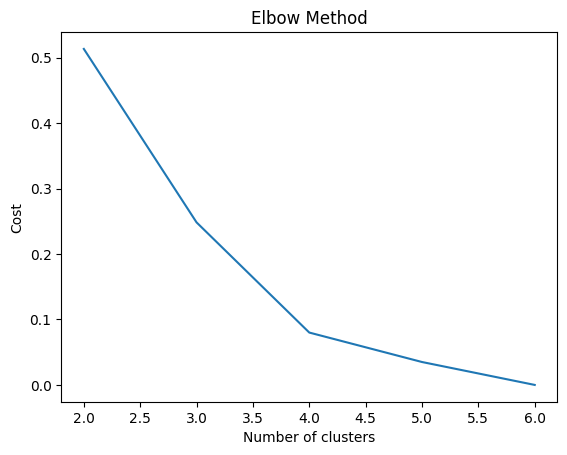

In [23]:
import matplotlib.pyplot as plt
# Mengimpor matplotlib untuk membuat grafik.

costs = []
for k in range(2, 7):
 kmeans = KMeans().setK(k).setSeed(1)
 model = kmeans.fit(scaled_df)
 cost = model.summary.trainingCost
 costs.append(cost)
 print(f"K={k}, WSSSE={costs[-1]}")
 # Loop dari K=2 sampai K=6

plt.plot(range(2, 7), costs)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()
# Membuat grafik Elbow

In [24]:
from pyspark.ml.feature import PCA
# Mengimpor PCA dari modul ML PySpark.

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
# Membuat objek PCA

pca_model = pca.fit(scaled_df)
# Melatih PCA model berdasarkan data.

pca_result = pca_model.transform(scaled_df)
# Menghasilkan DataFrame baru (pca_result) yang berisi hasil reduksi dimensi.

pca_result.select("pca_features").show(truncate=False)
# Menampilkan hasil PCA 2 dimensi untuk setiap data point.

+----------------------------------------+
|pca_features                            |
+----------------------------------------+
|[-3.5540691264840634,-5.181690130080334]|
|[-3.4683844688148184,-4.750235698266647]|
|[-3.2887208403812265,-4.753062654835078]|
|[-7.550562728189455,-5.077394269765552] |
|[-7.135091699496945,-4.679675606096402] |
|[-7.701700199921556,-4.86375149478825]  |
+----------------------------------------+



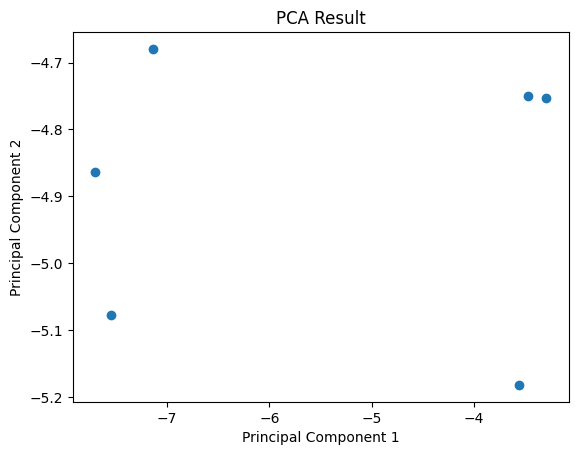

In [25]:
import numpy as np
# Mengimpor NumPy

pca_data = pca_result.select("pca_features").rdd.map(lambda x: x[0]).collect()
# Mengambil hasil kolom pca_features dari DataFrame

x = [float(d[0]) for d in pca_data]
y = [float(d[1]) for d in pca_data]
# Memisahkan komponen utama: x: sumbu komponen utama ke-1 (PC1). y: sumbu komponen utama ke-2 (PC2).

plt.scatter(x, y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()
# Membuat scatter plot 2D dari hasil PCA.

In [26]:
kmeans_pca = KMeans().setK(3).setSeed(1).setFeaturesCol("pca_features")
# Inisialisasi model KMeans

pca_kmeans_model = kmeans_pca.fit(pca_result)
# Melatih model KMeans dengan data hasil PCA

pca_predictions = pca_kmeans_model.transform(pca_result)
# Memberi label cluster ke tiap data → hasilnya disimpan di kolom "prediction".

pca_predictions.select("pca_features", "prediction").show()
# Kolom pca_features: vektor 2D hasil PCA. Kolom prediction: nomor cluster (misal 0, 1, 2).

+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-3.5540691264840...|         1|
|[-3.4683844688148...|         1|
|[-3.2887208403812...|         1|
|[-7.5505627281894...|         0|
|[-7.1350916994969...|         2|
|[-7.7017001999215...|         0|
+--------------------+----------+



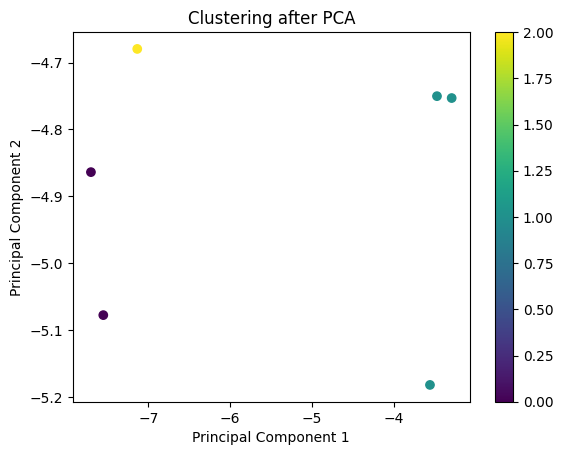

In [27]:
cluster_data = pca_predictions.select("pca_features", "prediction").collect()
# Ambil data PCA dan hasil cluster ke bentuk list Python.

x = [float(d[0][0]) for d in cluster_data]
y = [float(d[0][1]) for d in cluster_data]
clusters = [int(d[1]) for d in cluster_data]
# Pisahkan koordinat PCA dan cluster masing-masing.

plt.scatter(x, y, c=clusters)
# Plot titik dengan warna berdasarkan cluster.

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering after PCA')
plt.colorbar()
# Menampilkan legend warna cluster.

plt.show()